In [1]:
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('omw-1.4')

2024-02-13 19:39:47.136006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 19:39:47.136114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 19:39:47.293784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [2]:
df1 = pd.read_csv("/kaggle/input/fake-news-detection/Fake.csv")

In [3]:
df2 = pd.read_csv("/kaggle/input/fake-news-detection/True.csv")

In [4]:
df1.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
df2.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
df1["response"] = 1

In [7]:
df2["response"] = 0

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     23481 non-null  object
 1   text      23481 non-null  object
 2   subject   23481 non-null  object
 3   date      23481 non-null  object
 4   response  23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     21417 non-null  object
 1   text      21417 non-null  object
 2   subject   21417 non-null  object
 3   date      21417 non-null  object
 4   response  21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [10]:
df1.drop(["title","subject","date"],axis = 1,inplace = True)
df2.drop(["title","subject","date"],axis = 1,inplace = True)

In [11]:
merged_df = pd.concat([df1, df2], ignore_index=True)

In [12]:
merged_df

,text,response
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1
...,...,...
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0
44894,"LONDON (Reuters) - LexisNexis, a provider of l...",0
44895,MINSK (Reuters) - In the shadow of disused Sov...,0
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,0


In [13]:
df = merged_df.sample(frac=1,ignore_index=True)

In [14]:
df

,text,response
0,WASHINGTON (Reuters) - U.S. President Donald T...,0
1,MADRID (Reuters) - Spanish Prime Minister Mari...,0
2,"WASHINGTON (Reuters) - In late October, Presi...",0
3,PARIS (Reuters) - French businesses and foreig...,0
4,PARIS (Reuters) - Britain is becoming subservi...,0
...,...,...
44893,CNN recently broke the news that according to ...,1
44894,WASHINGTON (Reuters) - Democratic vice preside...,0
44895,Conservative commentator and devout Trump love...,1
44896,WASHINGTON (Reuters) - Vice President Joe Bide...,0


In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text
    
    return preprocessed_text


In [16]:
df["text"] = df["text"].apply(preprocess_text)

In [17]:
x = df["text"]
y = df["response"]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((35918,), (35918,), (8980,), (8980,))

In [19]:
# Tokenize the text data
max_words = 10000  #  Maximum number of words to consider
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()

In [21]:
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

model = LogisticRegression()

model.fit(x_train, y_train)

y_pred_lr = model.predict(x_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("Accuracy:", accuracy_lr)
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.9871937639198218
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4271
           1       0.99      0.98      0.99      4709

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [23]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train, y_train)

# Step 5: Evaluate classifier performance
y_pred = rf_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9909799554565701
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4271
           1       0.99      0.99      0.99      4709

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



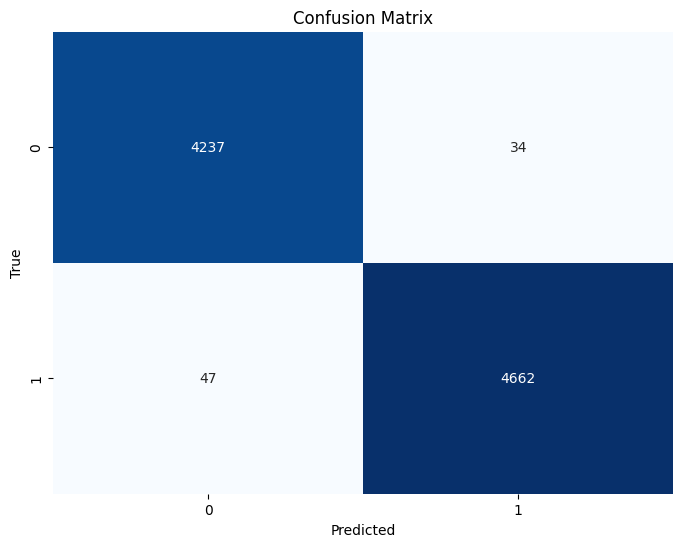

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()